In [1]:
# Importing python libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import load_img

In [2]:
# loading the dataset

from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()  

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# Num of samples we have for training and testing

train_X.shape, test_X.shape

((60000, 28, 28), (10000, 28, 28))

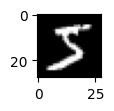

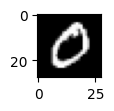

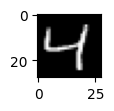

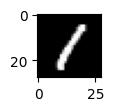

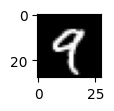

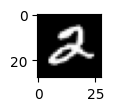

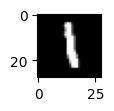

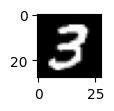

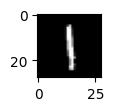

In [4]:
# Some Samples of data
#plt.figure(figsize=(20, 20))
for i in range(9):
  plt.subplot(5,5,i+1)
  plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
  plt.show()

In [5]:
from skimage.color import gray2rgb
vgg_train_X = gray2rgb(train_X)  # Convert grayscale to RGB format
vgg_train_X = tf.image.resize(vgg_train_X, (32, 32))  # Resizing image
vgg_train_X = vgg_train_X /255.
vgg_train_X = tf.keras.applications.vgg16.preprocess_input(vgg_train_X)  # Preprocess images

vgg_train_y = to_categorical(train_y, num_classes=10)  # Convert labels to one-hot encoding

In [6]:
vgg_test_X = gray2rgb(test_X)  # Convert grayscale to RGB format
vgg_test_X = tf.image.resize(vgg_test_X, (32, 32))  # Resizing image
vgg_test_X = vgg_test_X /255.
vgg_test_X = tf.keras.applications.vgg16.preprocess_input(vgg_test_X)  # Preprocess images

vgg_test_y = to_categorical(test_y, num_classes=10)  # Convert labels to one-hot encoding

In [7]:
# Common for all three models

# adaptive learning rate 
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# callbacks

callbacks = [
    EarlyStopping(monitor = 'accuracy', patience = 5),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-2),  
    LearningRateScheduler(scheduler), # here I use my learning rate changer (which is written above in the method)
]

# VGG16 Model

In [8]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
vgg_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [9]:
# Create a new Sequential model
model = Sequential()

# Add the VGG16 model as the base
model.add(vgg_model)

# Add the remaining layers
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(14, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 14)                7182      
                                                                 
 dense_1 (Dense)             (None, 12)                180       
                                                                 
 dense_2 (Dense)             (None, 10)                130       
                                                                 
Total params: 14,722,180
Trainable params: 7,492
Non-tra

In [12]:
hist=model.fit(x = vgg_train_X, y = vgg_train_y, batch_size = 64,epochs = 50,callbacks = callbacks, validation_split=0.2)

Epoch 1/50
750/750 [==============================] - 13s 15ms/step - loss: 2.2739 - accuracy: 0.1588 - val_loss: 2.0149 - val_accuracy: 0.2237 - lr: 0.0010
Epoch 2/50
750/750 [==============================] - 11s 15ms/step - loss: 2.0014 - accuracy: 0.2375 - val_loss: 1.8197 - val_accuracy: 0.3417 - lr: 0.0010
Epoch 3/50
750/750 [==============================] - 11s 14ms/step - loss: 1.8743 - accuracy: 0.2938 - val_loss: 1.6787 - val_accuracy: 0.3979 - lr: 0.0010
Epoch 4/50
750/750 [==============================] - 12s 16ms/step - loss: 1.8196 - accuracy: 0.3191 - val_loss: 1.6485 - val_accuracy: 0.4260 - lr: 9.0484e-04
Epoch 5/50
750/750 [==============================] - 12s 16ms/step - loss: 1.7851 - accuracy: 0.3391 - val_loss: 1.5963 - val_accuracy: 0.4655 - lr: 8.1873e-04
Epoch 6/50
750/750 [==============================] - 12s 16ms/step - loss: 1.7601 - accuracy: 0.3550 - val_loss: 1.5656 - val_accuracy: 0.4815 - lr: 7.4082e-04
Epoch 7/50
750/750 [==========================

In [13]:
loss, accuracy = model.evaluate(vgg_test_X, vgg_test_y)
print('Accuracy:', accuracy)

313/313 [==============================] - 3s 9ms/step - loss: 1.4019 - accuracy: 0.5654
Accuracy: 0.5654000043869019


# ResNet Model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from skimage.transform import resize

In [ ]:
# Load the MNIST dataset

(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [ ]:
resnet_train_X = np.expand_dims(train_X, axis=-1)  # Add channel dimension
resnet_train_X = resize(resnet_train_X, (60000, 32, 32, 3), mode='reflect')  # Resize images to 32x32x3
resnet_train_X = resnet_train_X.astype('float32') / 255.0  # Normalize pixel values between 0 and 1
resnet_train_X = tf.keras.applications.resnet50.preprocess_input(resnet_train_X)  # Preprocess images

resnet_train_y = to_categorical(train_y, num_classes=10)  # Convert labels to one-hot encoding

In [ ]:
# Load the pre-trained ResNet50 model

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet_model.trainable = False

In [ ]:
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(15, activation='relu')(x)
x = Dense(12, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

In [ ]:
model = Model(inputs=resnet_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

In [ ]:
model.fit(resnet_train_X, resnet_train_y, epochs=50, batch_size=32,callbacks = callbacks,validation_split=0.3)

Epoch 1/50
1313/1313 [==============================] - 31s 20ms/step - loss: 2.3043 - accuracy: 0.1130 - val_loss: 2.3018 - val_accuracy: 0.1079 - lr: 0.0010
Epoch 2/50
1313/1313 [==============================] - 30s 23ms/step - loss: 2.3011 - accuracy: 0.1143 - val_loss: 2.3017 - val_accuracy: 0.1079 - lr: 0.0010
Epoch 3/50
1313/1313 [==============================] - 28s 21ms/step - loss: 2.3011 - accuracy: 0.1143 - val_loss: 2.3018 - val_accuracy: 0.1079 - lr: 0.0010
Epoch 4/50
1313/1313 [==============================] - 30s 23ms/step - loss: 2.3011 - accuracy: 0.1143 - val_loss: 2.3019 - val_accuracy: 0.1079 - lr: 9.0484e-04
Epoch 5/50
1154/1313 [=========================>....] - ETA: 2s - loss: 2.3010 - accuracy: 0.1147

KeyboardInterrupt: ignored

# DenseNet Model

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from skimage.transform import resize

In [ ]:
# Load the MNIST dataset

(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [ ]:
densenet_train_X = np.expand_dims(train_X, axis=-1)  # Add channel dimension
densenet_train_X = resize(densenet_train_X, (60000, 32, 32, 3), mode='reflect')  # Resize images to 32x32x3
densenet_train_X = densenet_train_X.astype('float32') / 255.0  # Normalize pixel values between 0 and 1

densenet_train_y = to_categorical(train_y, num_classes=10)  # Convert labels to one-hot encoding

In [ ]:
train_X = tf.keras.applications.densenet.preprocess_input(densenet_train_X)

In [ ]:
# Load the pre-trained DenseNet121 model

densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
densenet_model.trainable = False

In [ ]:
x = densenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

In [ ]:
model = Model(inputs=densenet_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 16, 16, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1/conv[0][0]']       

In [ ]:
model.fit(densenet_train_X, densenet_train_y, epochs=50, batch_size=32,callbacks = callbacks,validation_split=0.3)

Epoch 1/50
1313/1313 [==============================] - 45s 27ms/step - loss: 2.3046 - accuracy: 0.1096 - val_loss: 2.3022 - val_accuracy: 0.1079 - lr: 0.0010
Epoch 2/50
1313/1313 [==============================] - 33s 25ms/step - loss: 2.3012 - accuracy: 0.1143 - val_loss: 2.3021 - val_accuracy: 0.1079 - lr: 0.0010
Epoch 3/50
1313/1313 [==============================] - 34s 26ms/step - loss: 2.3012 - accuracy: 0.1143 - val_loss: 2.3018 - val_accuracy: 0.1079 - lr: 0.0010
Epoch 4/50
1313/1313 [==============================] - 32s 24ms/step - loss: 2.3012 - accuracy: 0.1143 - val_loss: 2.3017 - val_accuracy: 0.1079 - lr: 9.0484e-04
Epoch 5/50
1313/1313 [==============================] - 35s 26ms/step - loss: 2.3011 - accuracy: 0.1143 - val_loss: 2.3020 - val_accuracy: 0.1079 - lr: 8.1873e-04
Epoch 6/50
1313/1313 [==============================] - 32s 24ms/step - loss: 2.3011 - accuracy: 0.1143 - val_loss: 2.3019 - val_accuracy: 0.1079 - lr: 7.4082e-04
Epoch 7/50
1313/1313 [============

In [ ]:
# from chat gpt
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from skimage.transform import resize

# Load the MNIST dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Data preprocessing
train_X = train_X.reshape(-1, 28, 28)
train_X = np.stack((train_X,) * 3, axis=-1)  # Convert grayscale to 3 channels
train_X = resize(train_X, (train_X.shape[0], 32, 32, 3), mode='reflect')  # Resize images to 32x32x3
train_X = train_X.astype('float32') / 255.0
train_y = to_categorical(train_y, num_classes=10)

# Create the model
densenet_model = tf.keras.applications.DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3)  # Update input shape to (32, 32, 3)
)
densenet_model.trainable = False

# Add custom dense layers
x = densenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# Compile the model
model = Model(inputs=densenet_model.input, outputs=predictions)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Adjust learning rate if needed
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
model.fit(train_X, train_y, epochs=100, batch_size=32, validation_split=0.3)

# Evaluate the model on the test set
(test_X, test_y) = mnist.load_data()
test_X = test_X.reshape(-1, 28, 28)
test_X = np.stack((test_X,) * 3, axis=-1)  # Convert grayscale to 3 channels
test_X = resize(test_X, (test_X.shape[0], 32, 32, 3), mode='reflect')  # Resize images to 32x32x3
test_X = test_X.astype('float32') / 255.0
test_y = to_categorical(test_y, num_classes=10)

_, test_accuracy = model.evaluate(test_X, test_y, verbose=0)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_6[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 16, 16, 64)   9408        ['zero_padding2d_6[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1/conv[0][0]']       